# Séries Temporelles

[![Index](https://img.shields.io/badge/Index-blue)](../index.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/digillia/Digillia-Colab/blob/main/use-cases/time-series.ipynb)

Les séries temporelles sont des données ordonnées chronologiquement, généralement collectées à intervalles réguliers, utilisées en machine learning pour analyser et prévoir des tendances temporelles. Elles se caractérisent par leur dépendance temporelle, chaque observation étant influencée par les précédentes. Les séries temporelles peuvent provenir de divers domaines, tels que la finance, la météo, la santé, ou l'industrie, et sont utiles pour prendre des décisions éclairées.

L'analyse des séries temporelles comprend plusieurs étapes, dont la visualisation des données, la détection de tendances, la saisonnalité et la modélisation des composantes. Les modèles couramment utilisés incluent les méthodes statistiques comme les ARIMA (AutoRegressive Integrated Moving Average), les modèles de réseaux de neurones récurrents (RNN) tels que les LSTM (Long Short-Term Memory), et les méthodes d'apprentissage profond comme les réseaux de neurones convolutifs 1D (CNN-1D).

Les séries temporelles servent à la prévision, à la détection d'anomalies, à l'optimisation des processus, et à la compréhension des phénomènes temporels. Elles sont essentielles dans de nombreux domaines, contribuant à la prise de décision basée sur des données historiques et à l'amélioration de la planification et de la gestion.

> <span style='color:red'>ATTENTION: notebook en cours d'élaboration!</span>

- https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
- https://anhhaibkhn.github.io/Data-Science-selfstudy-notes-Blog/seasonal%20data/forecast/arima/time%20series/arma/armax/aic/bic/acf/pacf/sarima/box-jenkins/2022/08/28/ARIMA-Models-in-Python.html
- https://github.com/mlflow/mlflow/blob/master/examples/pmdarima/train.py
- https://github.com/mlflow/mlflow/blob/master/examples/prophet/train.py

In [41]:
import os
import sys

# Supprimer les commentaires pour installer (requirements.txt)
# !pip3 install -q -U numpy
# !pip3 install -q -U pandas
# !pip3 install -q -U matplotlib
# !pip3 install -q -U scikit-learn
# !pip3 install -q -U pytrends
# !pip3 install -q -U statsmodels

# À installer dans tous les cas pour Google Colab et Github
if 'google.colab' in sys.modules or 'CI' in os.environ:
    !pip3 install -q -U skforecast
    # TODO https://facebook.github.io/prophet/
    # TODO https://github.com/ourownstory/neural_prophet 
    # TODO https://facebookresearch.github.io/Kats/
    # TODO https://github.com/winedarksea/AutoTS
    # TODO https://github.com/blue-yonder/tsfresh
    # TODO https://unit8co.github.io/darts/README.html
    # TODO https://github.com/sktime/sktime
    # TODO Check https://opentimeseries.com/ 

## Chargement des Données de Google Trends

In [42]:
# Mots clés
k_1 = 'parasol'
k_2 = 'crème solaire'
kw_list=[k_1, k_2]
work_directory = './time-series'

In [43]:
import pandas as pd

if 'google.colab' in sys.modules or 'CI' in os.environ:
    !curl --create-dirs -O --output-dir ${work_directory} "https://raw.githubusercontent.com/digillia/Digillia-Colab/main/use-cases/time-series/trend.csv"

if os.path.isfile(f'{work_directory}/trend.csv'):
    df = pd.read_csv(f'{work_directory}/trend.csv', parse_dates=True, index_col='date')
else:
    # Recherche sur Google Trends
    from pytrends.request import TrendReq
    pytrends = TrendReq(hl='fr-FR', tz=15)
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo='', gprop='')
    df = pytrends.interest_over_time()
    df.drop(columns=['isPartial'], inplace=True)
    df.to_csv(f'{work_directory}/trend.csv')
df = df.asfreq('MS')
df.head()

,parasol,crème solaire
date,,
2004-01-01,9,0
2004-02-01,8,1
2004-03-01,12,0
2004-04-01,19,1
2004-05-01,17,1


In [44]:
import pandas as pd

# Vérification qu'il n'y a pas de période manquante
(df.index == pd.date_range(start=df.index.min(), end=df.index.max(), freq=df.index.freq)).all()

np.True_

<Axes: xlabel='date'>

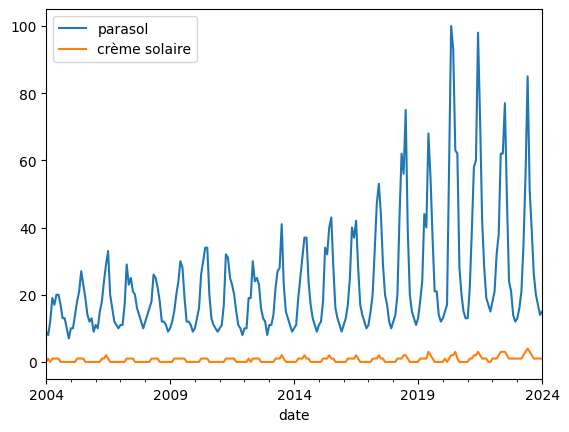

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

# Graphique
df.plot()

## Analyse des Caractéristiques de la Première Série (k_1)

Docs: https://machinelearningmastery.com/time-series-data-stationary-python/

In [46]:
df_1 = df[[k_1]]
df_1.shape

(241, 1)

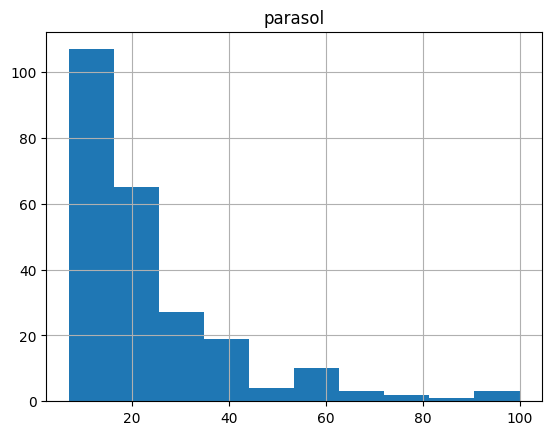

In [47]:
# Ce graphe indique clairement que la distribution des valeurs n'est pas Gaussienne
# et donc que cette série temporelle n'est pas stationnaire 
df_1.hist()
plt.show()

In [48]:
from statsmodels.tsa.stattools import adfuller

def print_adfuller(df):
  result = adfuller(df)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# C'est d'ailleurs confirmé par le test augmenté de Dicker-Fuller 
print_adfuller(df_1)

ADF Statistic: -0.921701
p-value: 0.780742
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [49]:
from numpy import log

# Log does not help
print_adfuller(log(df_1))

ADF Statistic: -0.926128
p-value: 0.779246
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [50]:
from statsmodels.tsa.tsatools import detrend

# "Detrend" d'un ordre de 5 rend la série temporelle stationaire au niveau de significance de 1%
d = 5 # essayer 4
df_1_detrend = detrend(df_1, order=d)
print_adfuller(df_1_detrend)

# df_1_trend = df_1 - df_1_detrend
# df_1 = df_1_trend + df_1_detrend

ADF Statistic: -4.117745
p-value: 0.000905
Critical Values:
	1%: -3.460
	5%: -2.874
	10%: -2.574


In [51]:
# Soustraire la moyenne glissante sur 12 mois est une autre façon de rendre la série temporelle stationaire au niveau de significance de 1%
# rolling_mean = df_1[k_1].rolling(window=12, center=True).mean()
# print_adfuller((df_1[k_1] - rolling_mean).dropna(inplace=True))

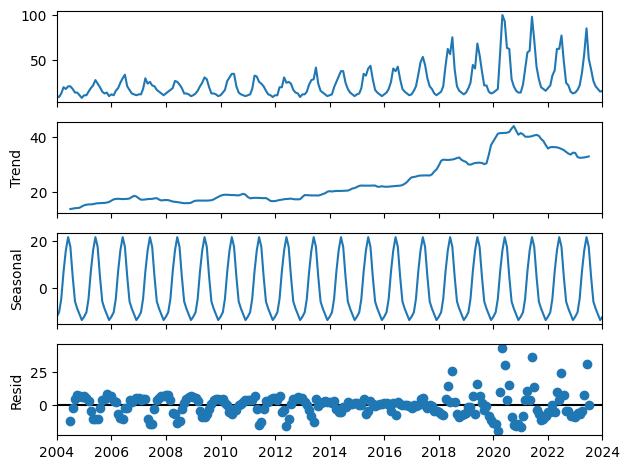

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_1, model='additive') # essayer 'multiplicative'
result.plot()
plt.show()

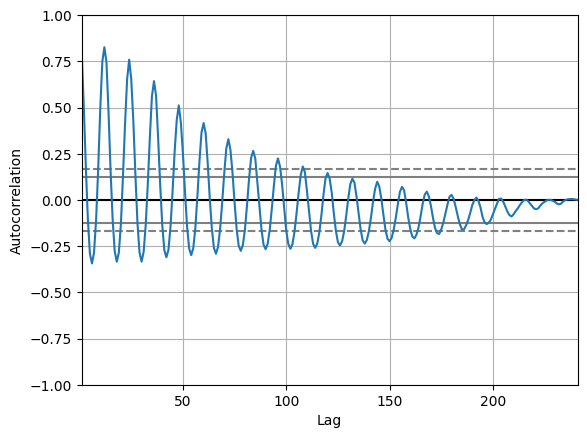

In [53]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_1)
plt.show()

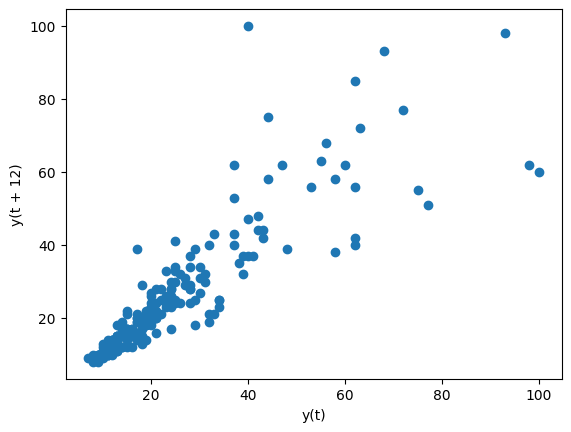

In [54]:
# We can check that there is a 12 month frequency (lag=12)
from pandas.plotting import lag_plot

lag_plot(df_1, lag=12)
plt.show()

## Graphes ACF et PACF

Docs: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf

<Figure size 1200x600 with 0 Axes>

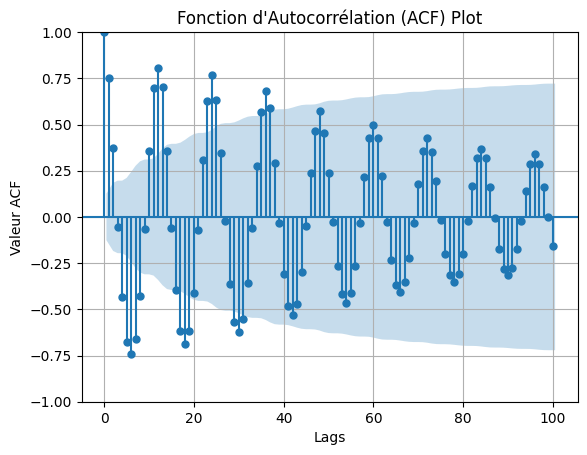

In [55]:
from statsmodels.graphics.tsaplots import plot_acf

# acf_values = sm.tsa.acf(df_1)
plt.figure(figsize=(12,6))
plot_acf(df_1_detrend, lags=100) #len(df_1)-1)
plt.title('Fonction d\'Autocorrélation (ACF) Plot')
plt.xlabel('Lags')
plt.ylabel('Valeur ACF')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

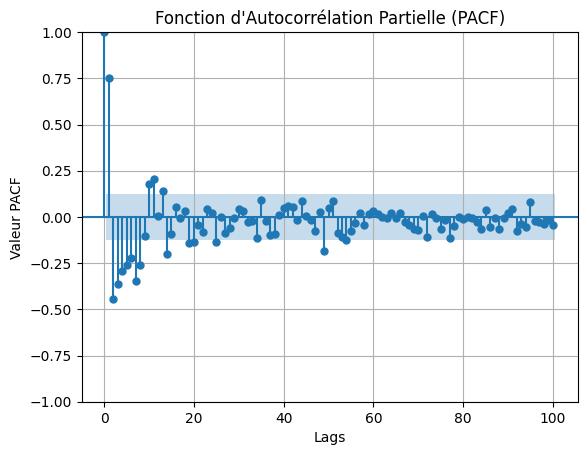

In [56]:
from statsmodels.graphics.tsaplots import plot_pacf

# pacf_values = sm.tsa.pacf(df_1)
plt.figure(figsize=(12,6))
plot_pacf(df_1_detrend, lags=100) #len(df_1)-1)
plt.title('Fonction d\'Autocorrélation Partielle (PACF)')
plt.xlabel('Lags')
plt.ylabel('Valeur PACF')
plt.grid(True)
plt.show()

## Création d'un Jeu d'Entraînement et de Test

Docs:
- https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

Total: 241
Entraînement: 193
Test: 48


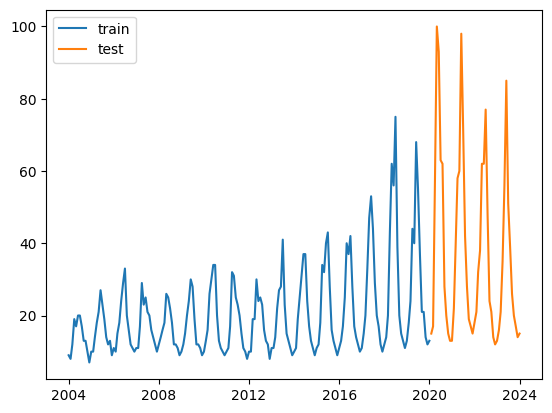

In [57]:
split = round(0.8*len(df_1))
train, test = df_1[0:split], df_1[split:]
print('Total:', len(df_1))
print('Entraînement:', len(train))
print('Test:', len(test))
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.legend()
plt.show()

## Prédictions avec SciKit-Learn (et skforecast)

In [58]:
from skforecast.recursive import ForecasterRecursive
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

random_state=42

forecaster = ForecasterRecursive(
    regressor=RandomForestRegressor(random_state=random_state),
    lags=12
)

forecaster.fit(y=train[k_1])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Window features: None 
Window size: 12 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2004-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-09 17:12:39 
Last fit date: 2024-12-09 17:12:39 
Skforecast version: 0.14.0 
Python version: 3.12.7 
Forecaster id: None

In [59]:
pred = forecaster.predict(steps=len(test))
pred.head(3)

2020-02-01    18.61
2020-03-01    32.45
2020-04-01    51.16
Freq: MS, Name: pred, dtype: float64

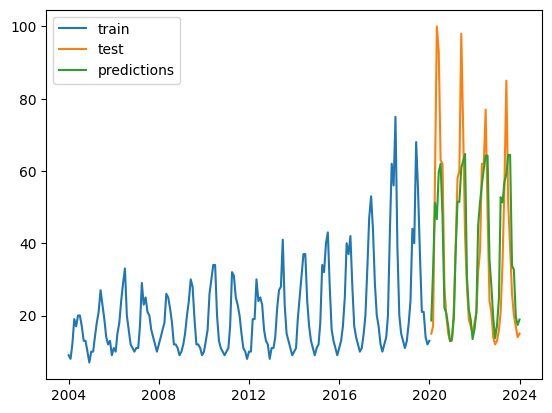

In [60]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

## Prédictions avec StatsModels

### Autorégression (AR)

In [61]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train, lags=12).fit()
pred = model.predict(len(train), len(train)+ len(test))
print(model.summary())
pred.head(3)

                            AutoReg Model Results                             
Dep. Variable:                parasol   No. Observations:                  193
Model:                    AutoReg(12)   Log Likelihood                -514.031
Method:               Conditional MLE   S.D. of innovations              4.141
Date:                Mon, 09 Dec 2024   AIC                           1056.062
Time:                        17:12:39   BIC                           1100.841
Sample:                    01-01-2005   HQIC                          1074.216
                         - 01-01-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4733      1.366      0.347      0.729      -2.204       3.150
parasol.L1      0.3730      0.072      5.154      0.000       0.231       0.515
parasol.L2      0.0785      0.070      1.125    

2020-02-01    14.502618
2020-03-01    29.918758
2020-04-01    37.301543
Freq: MS, dtype: float64

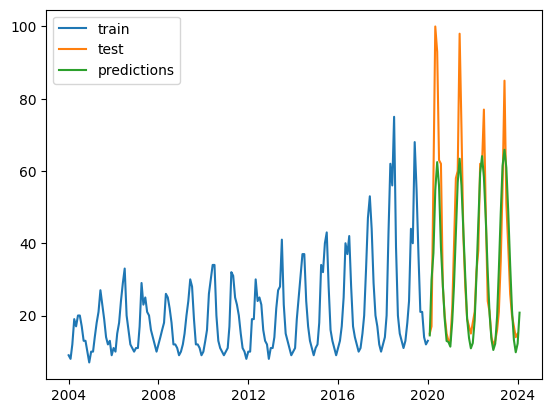

In [62]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

### Moyenne Mobile (MA - Moving Average)

In [63]:
from statsmodels.tsa.arima.model import ARIMA

order = (0, 0, 2) # paramètres (p,d,q) pour la moyenne mobile
model = ARIMA(train, order=order).fit()
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)

                               SARIMAX Results                                
Dep. Variable:                parasol   No. Observations:                  193
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -655.173
Date:                Mon, 09 Dec 2024   AIC                           1318.346
Time:                        17:12:41   BIC                           1331.397
Sample:                    01-01-2004   HQIC                          1323.631
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1085      2.026      9.927      0.000      16.138      24.079
ma.L1          0.9060      0.059     15.456      0.000       0.791       1.021
ma.L2          0.4595      0.082      5.575      0.0

2020-02-01    17.130711
2020-03-01    19.060114
2020-04-01    20.108518
Freq: MS, Name: predicted_mean, dtype: float64

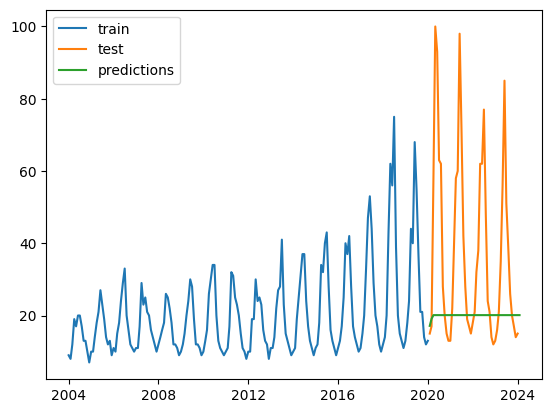

In [64]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

### Moyenne Mobile Autorégressive (ARMA - AutoRegressive Moving Average)

In [65]:
from statsmodels.tsa.arima.model import ARIMA

order = (12, 0, 12) # paramètres (p,d,q) pour la moyenne mobile autorégressive
model = ARIMA(train, order=order).fit()
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)

/Users/jlchereau/Projects/Digillia/Digillia-Colab/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                parasol   No. Observations:                  193
Model:               ARIMA(12, 0, 12)   Log Likelihood                -544.128
Date:                Mon, 09 Dec 2024   AIC                           1140.255
Time:                        17:12:42   BIC                           1225.085
Sample:                    01-01-2004   HQIC                          1174.609
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1782     16.525      1.221      0.222     -12.210      52.567
ar.L1          0.1485      0.594      0.250      0.803      -1.016       1.313
ar.L2          0.2565      0.542      0.473      0.6

/Users/jlchereau/Projects/Digillia/Digillia-Colab/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2020-02-01    10.736397
2020-03-01    24.331285
2020-04-01    36.342088
Freq: MS, Name: predicted_mean, dtype: float64

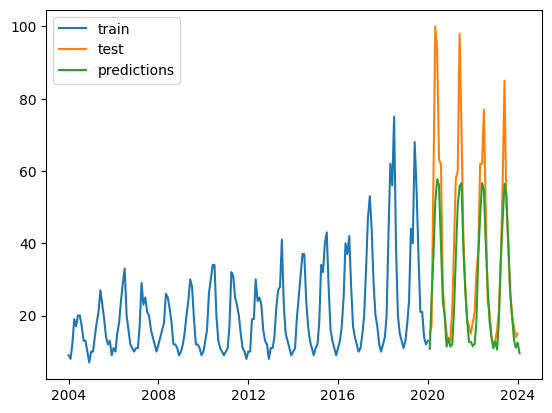

In [66]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

### ARIMA

In [67]:
from statsmodels.tsa.arima.model import ARIMA

order = (1, 1, 1) # paramètres (p,d,q) pour la moyenne mobile autorégressive
model = ARIMA(train, order=order).fit()
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)


                               SARIMAX Results                                
Dep. Variable:                parasol   No. Observations:                  193
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -653.087
Date:                Mon, 09 Dec 2024   AIC                           1312.175
Time:                        17:12:42   BIC                           1321.947
Sample:                    01-01-2004   HQIC                          1316.133
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4004      0.194      2.069      0.039       0.021       0.780
ma.L1         -0.1605      0.198     -0.809      0.418      -0.549       0.228
sigma2        52.7072      3.190     16.523      0.0

2020-02-01    13.116573
2020-03-01    13.163249
2020-04-01    13.181939
Freq: MS, Name: predicted_mean, dtype: float64

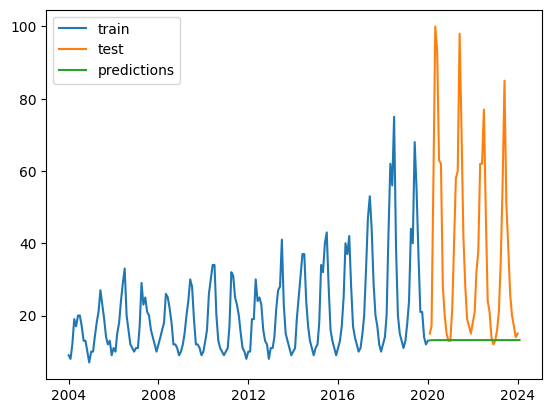

In [68]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

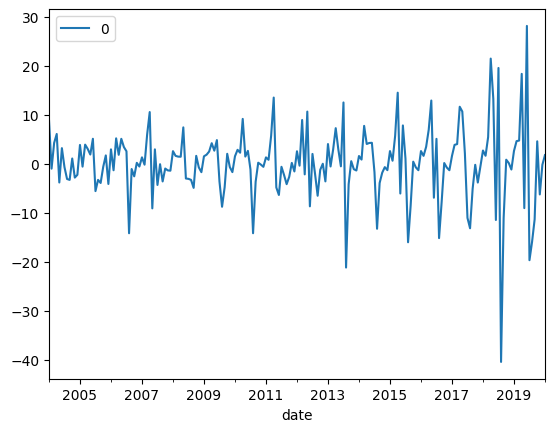

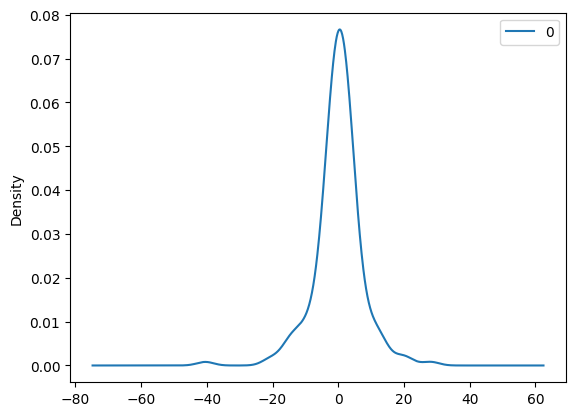

                0
count  193.000000
mean     0.062210
std      7.288775
min    -40.468220
25%     -2.827890
50%      0.147388
75%      2.963030
max     28.147150


In [69]:
# line plot of residuals
resid = pd.DataFrame(model.resid)
resid.plot()
plt.show()
# density plot of residuals
resid.plot(kind='kde')
plt.show()
# summary stats of residuals
print(resid.describe())

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1) # paramètres (p,d,q) pour la moyenne mobile autorégressive
seasonal_order=(1, 1, 1, 12)
model = SARIMAX(train, order=order, seasonal_order=seasonal_order).fit(maxiter=100, disp=False)
pred = model.predict(len(train), len(train) + len(test))
print(model.summary())
pred.head(3)

                                     SARIMAX Results                                      
Dep. Variable:                            parasol   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -529.553
Date:                            Mon, 09 Dec 2024   AIC                           1069.107
Time:                                    17:12:42   BIC                           1085.072
Sample:                                01-01-2004   HQIC                          1075.580
                                     - 01-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3411      0.056      6.065      0.000       0.231       0.451
ma.L1         -0.9552      0.030   

2020-02-01    18.543839
2020-03-01    25.034580
2020-04-01    43.979145
Freq: MS, Name: predicted_mean, dtype: float64

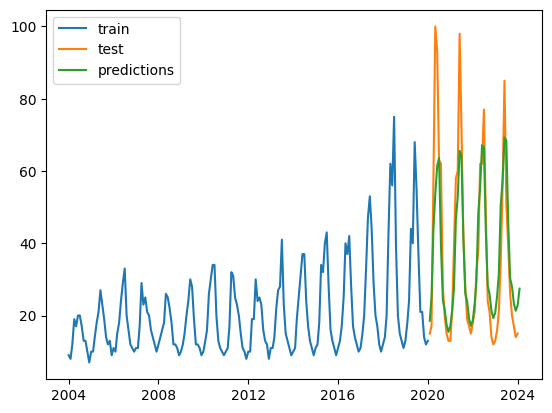

In [71]:
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()

Check:
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://blog.research.google/2024/03/autobnn-probabilistic-time-series.html
- https://blog.research.google/2024/02/a-decoder-only-foundation-model-for.html
- https://facebook.github.io/prophet/

